<a href="https://colab.research.google.com/github/AdrianRacki/AdrianRacki/blob/main/RON_v2__noH_GNNprediction_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment preparation

In [ ]:
!apt-get install -y python-rdkit librdkit1 rdkit-data
!pip install rdkit
!pip install tensorflow_gnn

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package python-rdkit
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.9/803.9 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.6/721.6 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.2/14.2 MB 51.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.0/152.0 kB 15.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 36.0 MB/s eta 0:00:00
     ━━━━━━━━━

In [ ]:
from rdkit import Chem
import networkx as nx
import pandas as pd
import numpy as np
import networkx as nx
import tensorflow as tf
import tensorflow_gnn as tfgnn
import urllib.request
import io
import zipfile
import sys
import os
from tensorflow_gnn.models import gcn
from tensorflow_gnn.models import graph_sage
from google.protobuf import text_format
import tensorflow_gnn.proto.graph_schema_pb2 as schema_pb2
import matplotlib.pyplot as plt


# Declare GraphSchema

In [ ]:
schema_pbtx = """
# proto-file: //third_party/py/tensorflow_gnn/proto/graph_schema.proto
# proto-message: tensorflow_gnn.GraphSchema
context {
  features {
    key: "label"
    value: {
      description: "RON"
      dtype: DT_FLOAT
    }
  }
}
context {
  features {
    key: "BP"
    value: {
      description: "BP"
      dtype: DT_FLOAT
    }
  }
}
context {
  features {
    key: "HV"
    value: {
      description: "HV"
      dtype: DT_FLOAT
    }
  }
}
context {
  features {
    key: "LD"
    value: {
      description: "LD"
      dtype: DT_FLOAT
    }
  }
}
node_sets {
  key: "atoms"
  value {
    features {
      key: "hidden_state"
      value {
        description: "atom type."
        dtype: DT_FLOAT
        shape { dim { size: 200 } }
      }
    }
  }
}
edge_sets {
  key: "bonds"
  value {
    source: "atoms"
    target: "atoms"
    features {
      key: "hidden_state"
      value {
        description: "bond type."
        dtype: DT_FLOAT
        shape { dim { size: 3 } }
      }
    }
  }
}
"""
graph_schema = text_format.Merge(schema_pbtx, schema_pb2.GraphSchema())
graph_tensor_spec = tfgnn.create_graph_spec_from_schema_pb(graph_schema)

In [ ]:
graph_tensor_spec

GraphTensorSpec({'context': ContextSpec({'features': {'BP': TensorSpec(shape=(1,), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(1,), dtype=tf.float32, name=None), 'HV': TensorSpec(shape=(1,), dtype=tf.float32, name=None), 'LD': TensorSpec(shape=(1,), dtype=tf.float32, name=None)}, 'sizes': TensorSpec(shape=(1,), dtype=tf.int32, name=None)}, TensorShape([]), tf.int32, None), 'node_sets': {'atoms': NodeSetSpec({'features': {'hidden_state': TensorSpec(shape=(None, 200), dtype=tf.float32, name=None)}, 'sizes': TensorSpec(shape=(1,), dtype=tf.int32, name=None)}, TensorShape([]), tf.int32, None)}, 'edge_sets': {'bonds': EdgeSetSpec({'features': {'hidden_state': TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)}, 'sizes': TensorSpec(shape=(1,), dtype=tf.int32, name=None), 'adjacency': AdjacencySpec({'#index.0': TensorSpec(shape=(None,), dtype=tf.int32, name=None), '#index.1': TensorSpec(shape=(None,), dtype=tf.int32, name=None)}, TensorShape([]), tf.int32, {'#index.0': 'ato

# Dataset path

In [ ]:
import tempfile
train_path = os.path.join(tempfile.gettempdir(), "/content/drive/MyDrive/RON_GNN_datasets/train_RON_DATASET_at_emb_TFR.tfrecords")
val_path = os.path.join(tempfile.gettempdir(), "/content/drive/MyDrive/RON_GNN_datasets/val_RON_DATASET_at_emb_TFR.tfrecords")

# Decode function and dataset to var



In [ ]:
def decode_fn(record_bytes):
  graph = tfgnn.parse_single_example(
      graph_tensor_spec, record_bytes, validate=True)

  # extract label from context and remove from input graph
  context_features = graph.context.get_features_dict()
  label = context_features.pop('label')
  new_graph = graph.replace_features(context=context_features)

  return new_graph, label

In [ ]:
train_ds = tf.data.TFRecordDataset([train_path]).map(decode_fn)
val_ds = tf.data.TFRecordDataset([val_path]).map(decode_fn)

# Verification of a single graph in the datasets

In [ ]:
g, y = train_ds.take(1).get_single_element()

In [ ]:
g

GraphTensor(
  context=Context(features={'BP': <tf.Tensor: shape=(1,), dtype=tf.float32>, 'HV': <tf.Tensor: shape=(1,), dtype=tf.float32>, 'LD': <tf.Tensor: shape=(1,), dtype=tf.float32>}, sizes=[1], shape=(), indices_dtype=tf.int32),
  node_set_names=['atoms'],
  edge_set_names=['bonds'])

In [ ]:
y

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.8270989], dtype=float32)>

In [ ]:
g.node_sets['atoms']

NodeSet(features={'hidden_state': <tf.Tensor: shape=(24, 200), dtype=tf.float32>}, sizes=[24])

In [ ]:
g.node_sets['atoms'].features[tfgnn.HIDDEN_STATE]

<tf.Tensor: shape=(24, 200), dtype=float32, numpy=
array([[-0.02823115,  0.0383647 , -0.29129818, ...,  0.00782956,
        -0.05795917,  0.02510627],
       [-0.02823115,  0.0383647 , -0.29129818, ...,  0.00782956,
        -0.05795917,  0.02510627],
       [-0.02823115,  0.0383647 , -0.29129818, ...,  0.00782956,
        -0.05795917,  0.02510627],
       ...,
       [-0.01091546, -0.03660307,  0.2754273 , ...,  0.06288143,
         0.02511847,  0.10804436],
       [-0.01091546, -0.03660307,  0.2754273 , ...,  0.06288143,
         0.02511847,  0.10804436],
       [-0.01091546, -0.03660307,  0.2754273 , ...,  0.06288143,
         0.02511847,  0.10804436]], dtype=float32)>

In [ ]:
g.edge_sets['bonds'].adjacency.source

<tf.Tensor: shape=(46,), dtype=int32, numpy=
array([ 0,  0,  0,  0,  1,  1,  1,  2,  2,  2,  3,  3,  3,  4,  4,  4,  5,
        5,  6,  6,  6,  7,  7,  1,  8,  9, 10,  2, 11, 12,  3,  5, 13,  4,
       14, 15, 16, 17, 18,  6,  7, 19, 20, 21, 22, 23], dtype=int32)>

In [ ]:
g.edge_sets['bonds'].adjacency.target

<tf.Tensor: shape=(46,), dtype=int32, numpy=
array([ 1,  8,  9, 10,  2, 11, 12,  3,  5, 13,  4, 14, 15, 16, 17, 18,  6,
        7, 19, 20, 21, 22, 23,  0,  0,  0,  0,  1,  1,  1,  2,  2,  2,  3,
        3,  3,  4,  4,  4,  5,  5,  6,  6,  6,  7,  7], dtype=int32)>

In [ ]:
g.edge_sets['bonds'].features[tfgnn.HIDDEN_STATE]

<tf.Tensor: shape=(46, 3), dtype=float32, numpy=
array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
      

In [ ]:
g.node_sets["atoms"].sizes

<tf.Tensor: shape=(1,), dtype=int32, numpy=array([24], dtype=int32)>

In [ ]:
g.context["BP"]

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.5289855], dtype=float32)>

# Batching

In [ ]:
batch_size = 32 #@param {type:"integer"}

train_ds_batched = train_ds.batch(batch_size=batch_size).repeat()
val_ds_batched = val_ds.batch(batch_size=batch_size)

# GAT model

In [ ]:
from tensorflow_gnn.models import gat_v2

In [ ]:
class MPNN(tf.keras.layers.Layer):
    """
    A basic stack of message-passing Graph Attention layers.
    """
    def __init__(self, hidden_size, hops, heads, name='gat_mpnn', **kwargs):
        self.hidden_size = hidden_size
        self.hops = hops
        self.heads = heads
        super().__init__(name=name, **kwargs)

        self.mp_layers = [self._mp_factory(name=f'message_passing_{i}') for i in range(hops)]

    # def _mp_factory(self, name):
    #   return gat_v2.GATv2HomGraphUpdate(
    #                                     num_heads=self.heads,
    #                                     per_head_channels=self.hidden_size,
    #                                     receiver_tag = tfgnn.SOURCE,
    #                                     feature_name = tfgnn.HIDDEN_STATE,
    #                                     heads_merge_type='mean',
    #                                     name='gat_v2')

    def _mp_factory(self, name):
      return gat_v2.GATv2GraphUpdate(num_heads=self.heads,
                                    per_head_channels=self.hidden_size,
                                    edge_set_name='bond',
                                    sender_edge_feature=tfgnn.HIDDEN_STATE,
                                    name=name)

    def get_config(self):
        config = super().get_config()
        config.update({
            'hidden_size': self.hidden_size,
            'hops': self.hops,
            "heads":self.heads
        })
        return config

    def call(self, graph_tensor):
        for layer in self.mp_layers:
            graph_tensor = layer(graph_tensor)
        return graph_tensor

In [ ]:
from tensorflow.python.eager.context import context
graph_convolution_type = "default"
def _build_model_GAT(
    graph_tensor_spec,
    node_dim=16,
    edge_dim=16,
    hidden_size=128,
    node_state_dim=64,
    hops=8,
    heads=8,
    l2_regularization=5e-4,
    dropout_rate=0.5,
):

  input_graph = tf.keras.layers.Input(type_spec=graph_tensor_spec)

  graph = input_graph.merge_batch_to_components()

  liq_dens = tf.expand_dims(graph.context.features["LD"], axis = -1)
  heat_vap = tf.expand_dims(graph.context.features["HV"], axis = -1)
  boil_point = tf.expand_dims(graph.context.features["BP"], axis = -1)
  num_atoms = tf.expand_dims(tf.cast(graph.node_sets["atoms"].sizes, dtype=tf.float32), axis=-1)
  num_bonds = tf.expand_dims(tf.cast(graph.edge_sets["bonds"].sizes, dtype=tf.float32), axis=-1)
  graph = graph.replace_features(
      context={
          tfgnn.HIDDEN_STATE: (tf.concat([liq_dens, heat_vap, boil_point, num_atoms, num_bonds], axis=1))
          })

  def set_initial_context_state(context):
    return tf.keras.layers.Dense(node_dim)(context[tfgnn.HIDDEN_STATE])

  def set_initial_node_state(node_set, *, node_set_name):
    return tf.keras.layers.Dense(node_dim, activation="relu")(node_set[tfgnn.HIDDEN_STATE])

  def set_initial_edge_state(edge_set, *, edge_set_name):
    if graph_convolution_type != "default":
      return {}
    return tf.keras.layers.Dense(edge_dim, activation="relu")(edge_set[tfgnn.HIDDEN_STATE])

  graph = tfgnn.keras.layers.MapFeatures(node_sets_fn=set_initial_node_state, edge_sets_fn=set_initial_edge_state, context_fn=set_initial_context_state)(
          graph)





  # num_atoms = tf.expand_dims(tf.cast(graph.node_sets["atoms"].sizes, dtype=tf.float32), axis=-1)
  # num_bonds = tf.expand_dims(tf.cast(graph.edge_sets["bonds"].sizes, dtype=tf.float32), axis=-1)
  # graph = graph.replace_features(
  #     context={
  #         tfgnn.HIDDEN_STATE: tf.concat([num_atoms, num_bonds], axis=1)
  #         })


  mpnn = MPNN(hidden_size, hops, heads)
  graph = mpnn(graph)

  # This helper function is just a short-hand for the code below.

  # def dense(units, activation="relu"):
  #   """A Dense layer with regularization (L2 and Dropout)."""
  #   regularizer = tf.keras.regularizers.l2(l2_regularization)
  #   return tf.keras.Sequential([
  #       tf.keras.layers.Dense(
  #           units,
  #           activation=activation,
  #           kernel_regularizer=regularizer,
  #           bias_regularizer=regularizer),
  #       tf.keras.layers.Dropout(dropout_rate)
  #   ])

  # for i in range(hops):
  #   graph = tfgnn.keras.layers.GraphUpdate(
  #       node_sets={"atoms": tfgnn.keras.layers.NodeSetUpdate(
  #           {"bonds": gat_v2.GATv2Conv(
  #               num_heads=heads,
  #               per_head_channels=hidden_size,
  #               receiver_tag=tfgnn.TARGET,
  #               sender_edge_feature=tfgnn.HIDDEN_STATE,
  #               heads_merge_type='concat')},
  #           tfgnn.keras.layers.NextStateFromConcat(dense(node_state_dim)))}
  #   )(graph)

  # graph = tfgnn.keras.layers.GraphUpdate(
  #     context=tfgnn.keras.layers.ContextUpdate(
  #         {"atoms": gat_v2.GATv2Conv(
  #             num_heads=heads,
  #             per_head_channels=hidden_size,
  #             receiver_tag=tfgnn.CONTEXT,
  #             sender_edge_feature=None,
  #             sender_node_feature=tfgnn.HIDDEN_STATE,
  #             heads_merge_type='concat')},
  #         tfgnn.keras.layers.NextStateFromConcat(dense(node_state_dim)))
  # )(graph)

  readout_features = tfgnn.keras.layers.Pool(
      tfgnn.CONTEXT, "mean", node_set_name="atoms")(graph)

  feat = tf.concat([readout_features, graph.context[tfgnn.HIDDEN_STATE]], axis=1)
  fn_dense = tf.keras.layers.Dense(16, activation="relu")(feat)
  logits = tf.keras.layers.Dense(1)(fn_dense)

  return tf.keras.Model(inputs=[input_graph], outputs=[logits])

In [ ]:
node_dim = 32 #@param {type:"integer"}
edge_dim = 32 #@param {type:"integer"}
hidden_size = 64 #@param {type:"integer"}
hops = 2 #@param {type:"integer"}
node_state_dim = 32 #@param {type:"number"}
l2_regularization = 5e-4 #@param {type:"number"}
dropout_rate = 0.5 #@param {type:"number"}
heads = 4 #@param {type:"number"}

del model

model_input_graph_spec, label_spec = train_ds.element_spec
model = _build_model_GAT(model_input_graph_spec,
                     node_dim=node_dim,
                     edge_dim=edge_dim,
                     hidden_size=hidden_size,
                     hops=hops,
                     node_state_dim=node_state_dim,
                     l2_regularization=l2_regularization,
                     dropout_rate=dropout_rate)

In [ ]:
loss = tf.keras.losses.MeanAbsoluteError()
metrics = [tf.keras.metrics.MeanAbsoluteError()]

In [ ]:
learning_rate = 1e-4 #@param {type:"number"}
learning_rate_decay = True #@param {type:"boolean"}
steps_per_epoch = 10 #@param {type:"integer"}
epochs = 300 #@param {type:"integer"}

if learning_rate_decay:
  learning_rate = tf.keras.optimizers.schedules.CosineDecay(learning_rate, steps_per_epoch*epochs)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer, loss=loss, metrics=metrics)
model.summary()

Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_173 (InputLayer)      [()]                         0         []                            
                                                                                                  
 input.merge_batch_to_compo  ()                           0         ['input_173[0][0]']           
 nents_61 (InstanceMethod)                                                                        
                                                                                                  
 input.node_sets_57 (Instan  {'atoms': ()}                0         ['input.merge_batch_to_compone
 ceProperty)                                                        nts_61[0][0]']                
                                                                                           

In [ ]:
history = model.fit(train_ds_batched,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_data=val_ds_batched)


Epoch 1/300
10/10 [==============================] - 8s 88ms/step - loss: 5.3326 - mean_absolute_error: 5.3326 - val_loss: 5.3444 - val_mean_absolute_error: 5.3444
Epoch 2/300
10/10 [==============================] - 0s 25ms/step - loss: 4.5276 - mean_absolute_error: 4.5276 - val_loss: 4.2557 - val_mean_absolute_error: 4.2557
Epoch 3/300
10/10 [==============================] - 0s 33ms/step - loss: 3.5312 - mean_absolute_error: 3.5312 - val_loss: 3.2205 - val_mean_absolute_error: 3.2205
Epoch 4/300
10/10 [==============================] - 0s 25ms/step - loss: 2.5859 - mean_absolute_error: 2.5859 - val_loss: 2.2990 - val_mean_absolute_error: 2.2990
Epoch 5/300
10/10 [==============================] - 0s 34ms/step - loss: 1.6471 - mean_absolute_error: 1.6471 - val_loss: 1.2810 - val_mean_absolute_error: 1.2810
Epoch 6/300
10/10 [==============================] - 0s 27ms/step - loss: 0.7202 - mean_absolute_error: 0.7202 - val_loss: 0.2401 - val_mean_absolute_error: 0.2401
Epoch 7/300
10/1

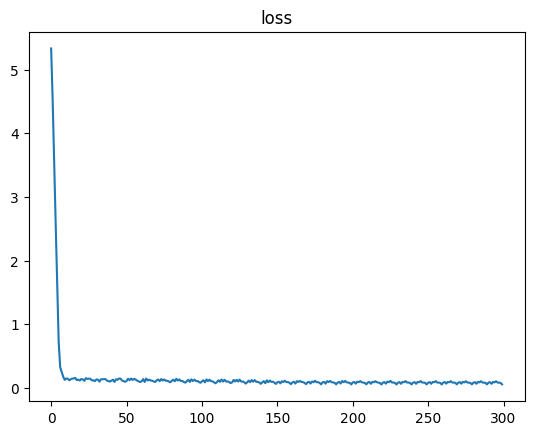

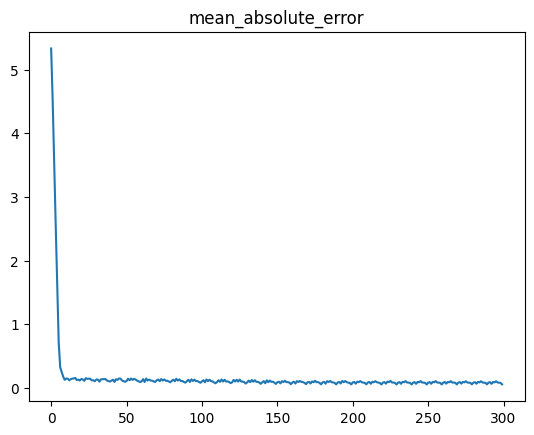

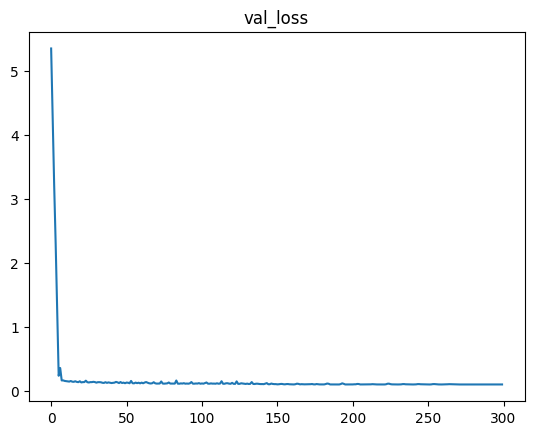

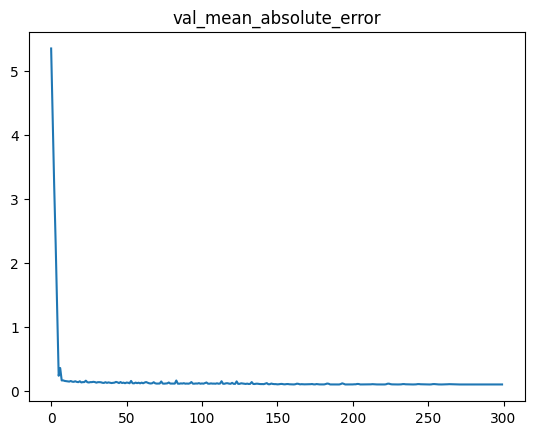

In [ ]:
for k, hist in history.history.items():
  plt.plot(hist)
  plt.title(k)
  plt.show()